In [1]:
import pulp
import numpy as np
import pandas as pd
import plotly.express as px

Source : https://or.stackexchange.com/questions/11506/algorithm-needed-to-find-optimum-area-of-2-dimensional-data-set

# 1. The data

In [111]:
np.random.seed(1)
#configuration for first array
mean0 = np.array([0., 0.])
cov0 = np.array([[1., 0.], [0., 1.]])
size0 = 100
# configuration for second array
mean1 = np.array([1., 1.])
cov1 = np.array([[.5, 0.], [0., .5]])
size1 = 100
# build first array
vals0 = np.random.multivariate_normal(mean0, cov0, size0)
# append another column to the right of the array
vals0 = np.append(vals0, [[-1] for x in range(size0)], axis=1)
# fill new column with randomized data (negative values)
vals0[:, 2] = -1.0 + 0.2 * np.random.random(size0)
# build second array
vals1 = np.random.multivariate_normal(mean1, cov1, size1)
# append another column to the right of the array
vals1 = np.append(vals1, [[-1] for x in range(size1)], axis=1)
# fill new column with randomized data (positive values)
vals1[:, 2] = 100.0 - 0.2 * np.random.random(size1)
# combine first and second array
vals2 = np.append(vals0, vals1, axis=0)
# convert numpy array to pandas DataFrame
df = pd.DataFrame(vals2, columns=['x', 'y', 'z'])
df

,x,y,z
0,1.624345,-0.611756,-0.827104
1,-0.528172,-1.072969,-0.935464
2,0.865408,-2.301539,-0.865842
3,1.744812,-0.761207,-0.909825
4,0.319039,-0.249370,-0.923579
...,...,...,...
195,0.703766,0.661165,99.818138
196,-0.380347,0.008404,99.878904
197,1.318992,0.508617,99.846645
198,1.364453,0.211667,99.899060


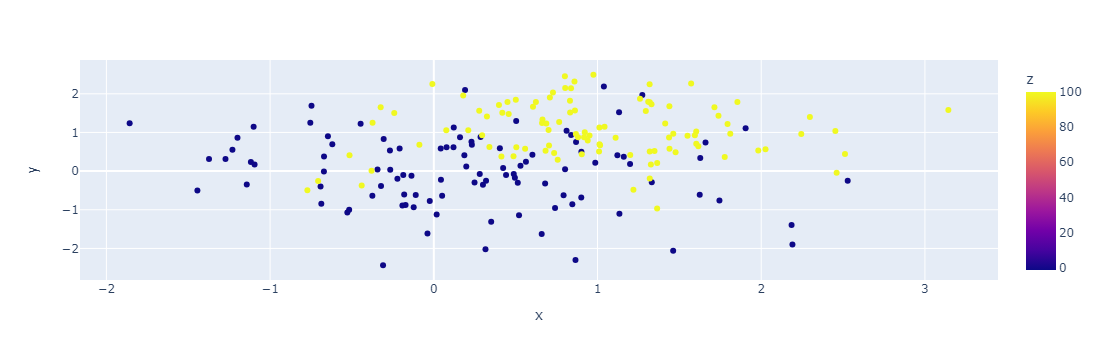

In [112]:
fig = px.scatter(df,x="x",y="y",color="z")
#fig.update_yaxes(scaleanchor="x",scaleratio=1,)
fig.show()

# 2. Optimization

In [113]:
# data and constants
points_score = dict(zip(df.index,df.z))
points_x = dict(zip(df.index,df.x))
points_y = dict(zip(df.index,df.y))
largest_x = max(df.x)
largest_y = max(df.y)
smallest_x = min(df.x)
smallest_y = min(df.y)
TOL = 1e-3 

# problem definition
prob = pulp.LpProblem("2D", pulp.LpMaximize)

# variables
s = pulp.LpVariable.dicts("s", points_score, cat=pulp.LpBinary)
l = pulp.LpVariable.dicts("l", points_score, cat=pulp.LpBinary)
r = pulp.LpVariable.dicts("r", points_score, cat=pulp.LpBinary)
b = pulp.LpVariable.dicts("b", points_score, cat=pulp.LpBinary)
a = pulp.LpVariable.dicts("a", points_score, cat=pulp.LpBinary)
x_min = pulp.LpVariable("x_min",cat=pulp.LpContinuous, lowBound=smallest_x, upBound=largest_x)
x_max = pulp.LpVariable("x_max",cat=pulp.LpContinuous, lowBound=smallest_x, upBound=largest_x)
y_min = pulp.LpVariable("y_min",cat=pulp.LpContinuous, lowBound=smallest_y, upBound=largest_y)
y_max = pulp.LpVariable("y_max",cat=pulp.LpContinuous, lowBound=smallest_y, upBound=largest_y)

# objective function
prob += pulp.lpSum(points_score[i]*s[i] for i in s)

# constraints
M= 10
for i in s:
    prob += s[i] + l[i] + r[i] + b[i] + a[i] >= 1
    
    # s_i = 1 => x_min <= x_i
    M_i = largest_x - points_x[i]
    prob += x_min - points_x[i] <= M_i*(1-s[i])
    
    # s_i = 1 => x_max >= x_i
    M_i = points_x[i] - smallest_x
    prob += points_x[i] - x_max <= M*(1-s[i])
    
    # s_i = 1 => y_min <= y_i
    M_i = largest_y - points_y[i]
    prob += y_min - points_y[i] <= M_i*(1-s[i])
    
    # s_i = 1 => y_max >= y_i
    M_i = points_y[i] - smallest_y
    prob += points_y[i] - y_max <= M*(1-s[i])
    
    # l_i = 1 => x_min > x_i
    M_i = points_x[i] - smallest_x + TOL
    prob += points_x[i] - x_min + TOL <= M_i*(1-l[i])
    
    # r_i = 1 => x_max < x_i
    M_i = largest_x - points_x[i] + TOL
    prob += x_max - points_x[i] + TOL <= M_i*(1-r[i])
    
    # b_i = 1 => y_min > y_i
    M_i = points_y[i] - smallest_y + TOL
    prob += points_y[i] - y_min + TOL <= M*(1-b[i])
    
    # a_i = 1 => y_max < y_i
    M_i = largest_y - points_y[i] + TOL
    prob += y_max - points_y[i] + TOL <= M*(1-a[i])

# rob's solution
#prob += x_min == -0.12689
#prob += x_max == 2.4819
#prob += y_min == -0.29736
#prob += y_max == 2.6423

In [114]:
prob.solve(pulp.PULP_CBC_CMD(timeLimit=10))

1

In [115]:
# display coordinates of rectangle
pulp.value(x_min),pulp.value(x_max),pulp.value(y_min),pulp.value(y_max)

(-1.0939118, 3.1431396, -0.99602683, 2.4924231)

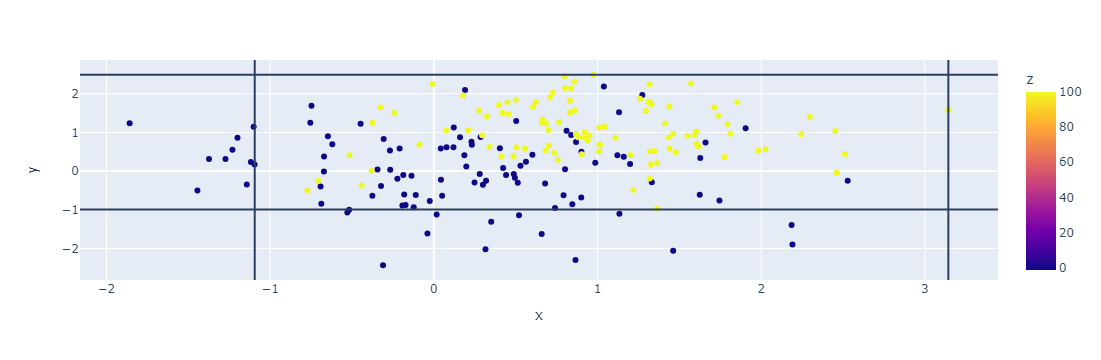

In [116]:
fig = px.scatter(df,x="x",y="y",color="z")
#fig.update_yaxes(scaleanchor="x",scaleratio=1,)
fig.add_hline(y=pulp.value(y_min))
fig.add_hline(y=pulp.value(y_max))
fig.add_vline(x=pulp.value(x_min))
fig.add_vline(x=pulp.value(x_max))
fig.show()